# Psychometric Curve

## Import Libraries and functions

In [2]:
import numpy as np
import pandas as pd
import os, requests

import matplotlib.cm as cm
colormap = cm.viridis

from functions import hide_toggle
hide_toggle()

In [3]:
import functions
# dir(functions)

## Import plot functions and define parameters

In [4]:
# import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True


Bad key savefig.frameon in file C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 473 ('verbose.fileo  : sys.stdout  # a log filename, sys.stdout or sys.stderr')
You probably need to get an updated matplotlibrc fil

## Load data

In [5]:
# Load Data
from functions import load_names # a function to get the file names

In [6]:
# This part takes time
fname = [] # initialize the list
fname = load_names()
print(fname)

# Data loading
alldat = np.array([])
for j in range(len(fname)):
    alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

['steinmetz_part0.npz', 'steinmetz_part1.npz', 'steinmetz_part2.npz']


In [7]:
alldat.shape

(39,)

## Select session and group brain regions

Function: dat, barea, NN, regions, brain_groups, nareas = load_data(n_session)

In [8]:
from functions import load_data

## Define functions: contrast difference & total contrast

Function: dt, NT, task_diff, dtask_diff, dtdiff = get_task_difference(n_session)

In [9]:
def get_task_difference(n_session):
    dat, barea, NN, regions, brain_groups, nareas = load_data(n_session, alldat)

    dt = dat['bin_size'] # binning at 10 ms
    NT = dat['spks'].shape[-1]

    l_cont = dat['contrast_left']         # contrast left
    r_cont = dat['contrast_right']        # contrast right
    
    cont_diff = l_cont - r_cont   # contrast difference
    abs_task_diff = np.abs(l_cont - r_cont)   # absolute contrast difference
    dtask_diff = np.diff(abs_task_diff)       # change in contrast difference (current - previous)
#     print(np.unique(dtask_diff))
    dtdiff = np.insert(dtask_diff, 0, 0)  # adjust the array size
#     print(dtdiff.shape)

    return dt, NT, cont_diff, abs_task_diff, dtask_diff, dtdiff

# dt, NT, task_diff, dtask_diff, dtdiff = get_task_difference(1)

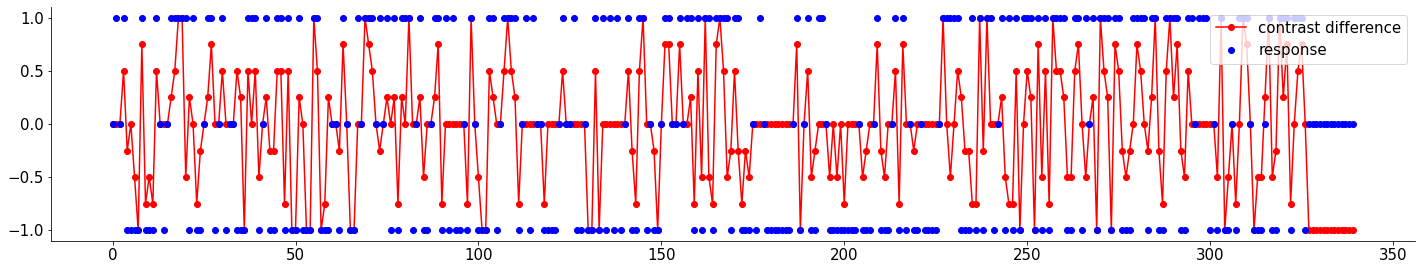

In [10]:
n_session = 11
dat, barea, NN, regions, brain_groups, nareas = load_data(n_session, alldat)

_, _, cont_diff, _, _, _ = get_task_difference(n_session)
plt.plot(cont_diff,'ro-', label='contrast difference')
plt.plot(dat['response'],'bo', label='response')
plt.legend()
plt.show()

In [11]:
print(len(cont_diff))
unique, counts = np.unique(cont_diff, return_counts=True) # check the contrast differences and the number of occurences
dict(zip(unique,counts))

340


{-1.0: 35,
 -0.75: 24,
 -0.5: 28,
 -0.25: 24,
 0.0: 126,
 0.25: 25,
 0.5: 37,
 0.75: 20,
 1.0: 21}

In [12]:
print('session: ', n_session)
print('contrast difference:', np.unique(cont_diff)[-1],' occurence:', counts[-1])
resp = (dat['response'][cont_diff==1])
# np.sum(resp)
# np.count_nonzero(resp==1)
# resp.shape

session:  11
contrast difference: 1.0  occurence: 21


### Plot Rightward choice over contrast difference

In [13]:
# This cell is for model fitting (psychometric curve)
from scipy.optimize import curve_fit
from functions import logistic_function as func

In [14]:
# def model_fit(func, xdata, ydata):
#     '''
#     For some reason, curve_fit doesn't work for the original data.
#     Here, ydata is divided by 10 and the fit parameters are adjusted.
#     '''
#     popt, pcov = curve_fit(func, xdata, ydata/10)
#     popt_correct = np.array([popt[0], popt[1], popt[2]*10, popt[3]])
#     return popt_correct

In [21]:
from functions import get_rightward
rightward = get_rightward(dat, cont_diff)

[ 96.15384615  93.33333333 100.          81.25        27.5862069
  21.05263158   7.69230769  17.64705882   4.34782609]


In [18]:
xdata

array([-1.  , -0.75, -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ])

[62.85714286 91.66666667 82.14285714 91.66666667 37.3015873  16.
  2.7027027   0.          0.        ]


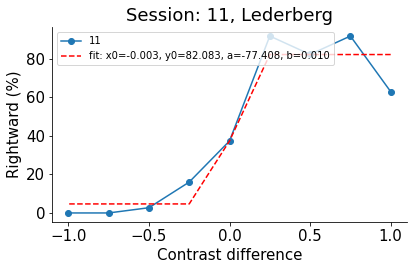

In [17]:
from functions import get_rightward # Get the % of rightward choice

# ========== Select session number ==========
n_session=11
dat, _, _, _, _, _ = load_data(n_session, alldat)
_, _, cont_diff, _, _, _ = get_task_difference(n_session)
rightward = get_rightward(dat, cont_diff)

xdata = np.unique(cont_diff)
ydata = rightward

# ========== Compute model fit (psychometric curve) ==========
popt, pcov = curve_fit(func, xdata, ydata)
# popt = model_fit(func, xdata, ydata)

# ========== Plot ==========
fig = plt.figure(figsize=(6,4))

plt.plot(-xdata, ydata,'o-', label=n_session)
plt.plot(-xdata, func(xdata, *popt), 'r--',
         label='fit: x0=%5.3f, y0=%5.3f, a=%5.3f, b=%5.3f' % tuple(popt))

plt.xlabel('Contrast difference')
plt.ylabel('Rightward (%)')
plt.title('Session: %1.0f, '%n_session + dat['mouse_name'])
plt.legend(loc='upper left', fontsize=10)
plt.show()

### 39 Sessions

[80.95238095 27.27272727 71.42857143 46.15384615 27.5862069   0.
  4.16666667  0.          0.        ]
[40.47619048 66.66666667 77.77777778 56.25       25.28735632 12.5
 13.33333333 10.52631579  0.        ]
[55.88235294 73.33333333 80.76923077 66.66666667 33.67346939  0.
 15.78947368 10.          0.        ]
[85.71428571 92.30769231 60.86956522 56.66666667 14.11764706  3.57142857
 11.53846154  5.88235294  0.        ]
[78.94736842 93.75       84.61538462 45.45454545 29.47368421 14.28571429
 10.          4.76190476  7.14285714]
[100.          91.66666667  87.5         73.33333333  21.
  17.14285714  22.72727273  12.5          5.26315789]
[100.          60.86956522  91.30434783  78.26086957  34.31372549
  42.85714286  22.58064516  15.38461538   0.        ]
[61.29032258 57.14285714 60.         50.         10.52631579  0.
 10.          0.          0.        ]
[65.71428571 81.81818182 82.14285714 54.83870968 16.66666667 10.52631579
  0.          5.          0.        ]
[59.45945946 64.285714

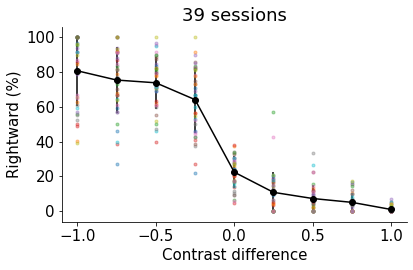

In [19]:
fig = plt.figure(figsize=(6,4))

# ========== Select session number ==========
rt_data = np.zeros((39,9))

for n_session in range(39):
    dat, _, _, _, _, _ = load_data(n_session, alldat)
    _, _, cont_diff, _, _, _ = get_task_difference(n_session)
    rightward = get_rightward(dat, cont_diff)
    rt_data[n_session,:]=rightward
    # ========== Plot ==========
    plt.plot(np.unique(cont_diff),rightward,'.', label=n_session, alpha=0.4)

# ========== Comput and plot mean and variance ==========
rt_mean = np.zeros(9)
for i in range(9):
    rt_mean[i] = np.mean(rt_data[:,i])
#     print(np.std(rt_data[:,i]))
    plt.errorbar(np.unique(cont_diff)[i], np.mean(rt_data[:,i]), np.std(rt_data[:,i]), fmt='-ko')
plt.plot(np.unique(cont_diff), rt_mean, 'k-', alpha=1)
plt.xlabel('Contrast difference')
plt.ylabel('Rightward (%)')
plt.title('39 sessions')
# plt.legend()
plt.show()

## History Dependence

In [22]:
def get_right_hist(dat, cont_diff):
    """
    Inputs: 
        * dat - trial data 
        * cont_diff - contrast difference between left and right
    Return:
        * reasy_l - % of mice respond right for each contrast difference, previous trial is easy left
        * rdiff_l - % of mice respond right for each contrast difference, previous trial is difficult left
        * reasy_r - % of mice respond right for each contrast difference, previous trial is easy right
        * rdiff_r - % of mice respond right for each contrast difference, previous trial is difficult right
    """
    unique, counts = np.unique(cont_diff, return_counts=True) # check the contrast differences and the number of occurences

    n_el = n_dl = n_er = n_dr = n_zero = 0
    
    # Define easy/difficult left/right (boolean array)
    easy_l = (cont_diff==-1)    #+ (cont_diff==-0.75)
    diff_l = (cont_diff==-0.25) #+ (cont_diff==-0.5)
    diff_r = (cont_diff==0.25)  #+ (cont_diff==0.5)
    easy_r = (cont_diff==1)     #+ (cont_diff==0.75)

    reasy_l = np.zeros((easy_l.sum(),9,2)) # 59 x 9
    rdiff_l = np.zeros((diff_l.sum(),9,2)) # 52 x 9
    reasy_r = np.zeros((easy_r.sum(),9,2)) # 41 x 9
    rdiff_r = np.zeros((diff_r.sum(),9,2)) # 62 x 9
    rzero = np.zeros(((cont_diff==0).sum(),9,2)) # 126 x 9

    # Check the number of trials for each difficulties 
    n_trials = np.zeros(6)
    n_trials[0] = rzero.shape[0] 
    n_trials[1] = reasy_l.shape[0]
    n_trials[2] = rdiff_l.shape[0]
    n_trials[3] = rdiff_r.shape[0]
    n_trials[4] = reasy_r.shape[0]
    n_trials[5] = dat['spks'].shape[1]
    
    for i in range(len(dat['response'])-1):
        hist = cont_diff[i]                                  # previous trial difficulty (size) & direction (sign)
        idx_cont = np.where(unique==cont_diff[i+1])[0][0]   # current trial difficulty and direction label (9 unique labels)

        if hist == -1: #in unique[0:2]: # easy left
            reasy_l[n_el, idx_cont,0] = dat['response'][i+1]
            reasy_l[0,idx_cont,1] +=1
            n_el += 1
        elif hist == -0.25: #in unique[2:4]: # difficult left
            rdiff_l[n_dl, idx_cont,0] = dat['response'][i+1]
            rdiff_l[0, idx_cont,1] += 1
            n_dl += 1
        elif hist == 0.25: #in unique[5:7]: # difficult right
            rdiff_r[n_dr, idx_cont,0] = dat['response'][i+1]
            rdiff_r[0, idx_cont,1] += 1
            n_dr += 1
        elif hist == 1.0: #in unique[7:9]: # easy right
            reasy_r[n_er, idx_cont,0] = dat['response'][i+1]
            reasy_r[0, idx_cont,1] += 1
            n_er += 1
        elif hist == 0:
            rzero[n_zero, idx_cont,0] = dat['response'][i+1]
            rzero[0, idx_cont,1] += 1
            n_zero += 1
        else:
            hist += 1 # some action. (whatever is fine to pass)
    #         print('Check: something is wrong')

    # Use np.divide(a, b, out=np.zeros(a.shape), where=b!=0) to avoid 0 division error
    r_easyr = np.divide(np.count_nonzero(reasy_r[:,:,0]==1,axis=0),
                        reasy_r[0,:,1], 
                        out=np.zeros(np.count_nonzero(reasy_r[:,:,0]==1,axis=0).shape), 
                        where=(reasy_r[0,:,1]!=0)) * 100
    r_easyl = np.divide(np.count_nonzero(reasy_l[:,:,0]==1,axis=0),
                        reasy_l[0,:,1], 
                        out=np.zeros(np.count_nonzero(reasy_l[:,:,0]==1,axis=0).shape), 
                        where=(reasy_l[0,:,1]!=0)) * 100
    r_diffr = np.divide(np.count_nonzero(rdiff_r[:,:,0]==1,axis=0),
                        rdiff_r[0,:,1], 
                        out=np.zeros(np.count_nonzero(rdiff_r[:,:,0]==1,axis=0).shape), 
                        where=(rdiff_r[0,:,1]!=0)) * 100
    r_diffl = np.divide(np.count_nonzero(rdiff_l[:,:,0]==1,axis=0),
                        rdiff_l[0,:,1], 
                        out=np.zeros(np.count_nonzero(rdiff_l[:,:,0]==1,axis=0).shape), 
                        where=(rdiff_l[0,:,1]!=0)) * 100
    r_zero = np.divide(np.count_nonzero(rzero[:,:,0]==1,axis=0),
                       rzero[0,:,1], 
                       out=np.zeros(np.count_nonzero(rzero[:,:,0]==1,axis=0).shape), 
                       where=(rzero[0,:,1]!=0)) * 100
        
    return r_easyr, r_easyl, r_diffr, r_diffl, r_zero, n_trials
hide_toggle()

In [26]:
def plot_hist(n_session, dat, cont_diff, rightward, r_diffr, r_easyr, r_easyl, r_diffl):
    fig = plt.figure(figsize=(7,5))

    xdata = np.unique(cont_diff)
    plt.plot(-xdata, rightward,'bo-', label='all (%1.0f)'%n_trials[-1])
#     popt,_ = curve_fit(func, xdata, rightward)
#     plt.plot(xdata, func(xdata, *popt), 'b:',
#              label='fit: all')

    plt.plot(xdata, r_diffr,'g.-',   label='diff_r (%1.0f)'%n_trials[3], alpha=0.5)
#     popt,_ = curve_fit(func, xdata, r_diffr)
#     plt.plot(xdata, func(xdata, *popt), 'g:',
#              label='fit: diff_r')

    plt.plot(xdata, r_easyr,'y.-',  label='easy_r (%1.0f)'%n_trials[4], alpha=0.5)
#     popt,_ = curve_fit(func, xdata, r_easyr)
#     plt.plot(xdata, func(xdata, *popt), 'y:',
#              label='fit: easy_r')

    plt.plot(xdata, r_zero ,'ro-',   label='zero (%1.0f)'%n_trials[0])
#     popt,_ = curve_fit(func, xdata, r_zero)
#     plt.plot(xdata, func(xdata, *popt), 'r:',
#              label='fit: zero')

    plt.plot(xdata, r_easyl,'c.-',  label='easy_l (%1.0f)'%n_trials[1], alpha=0.5)
#     popt,_ = curve_fit(func, xdata, r_easyl)
#     plt.plot(xdata, func(xdata, *popt), 'c:',
#              label='fit: easy_l')

    plt.plot(xdata, r_diffl,'m.-',   label='diff_l (%1.0f)'%n_trials[2], alpha=0.5)
#     popt,_ = curve_fit(func, xdata, r_diffl)
#     plt.plot(xdata, func(xdata, *popt), 'm:',
#              label='fit: diff_l')

    plt.xlabel('Contrast difference')
    plt.ylabel('Rightward (%)')
    plt.title('Session: %1.0f, '%n_session + dat['mouse_name'])
    plt.legend(fontsize=8)
    plt.show()

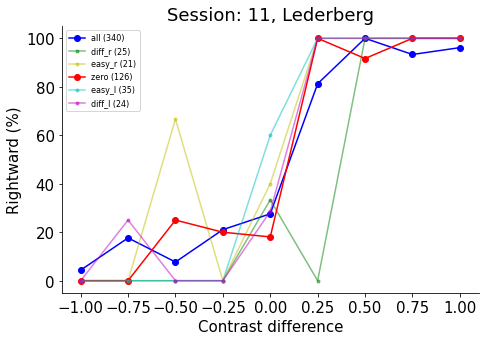

In [27]:
# ========== Select session number ==========
n_session=11
dat, _, _, _, _, _ = load_data(n_session, alldat)
_, _, cont_diff, _, _, _ = get_task_difference(n_session)
r_easyr, r_easyl, r_diffr, r_diffl, r_zero, n_trials = get_right_hist(dat, cont_diff)
# ========== Plot ==========
plot_hist(n_session, dat, cont_diff, rightward, r_diffr, r_easyr, r_easyl, r_diffl)

In [52]:
rer = rel = rdr = rdl = rz = np.zeros(9)

for i in range(39):
    n_session = i
    dat, _, _, _, _, _ = load_data(n_session, alldat)
    _, _, cont_diff, _, _, _ = get_task_difference(n_session)
    r_easyr, r_easyl, r_diffr, r_diffl, r_zero, n_trials = get_right_hist(dat, cont_diff)

    rdr = rdr + r_diffr
    rdl = rdl + r_diffl
    rer = rer + r_easyr
    rel = rel + r_easyl
    rz  = rz + r_zero

In [53]:
rer = rer/39
rel = rel/39
rdl = rdl/39
rz = rz/39
rdr = rdr/39

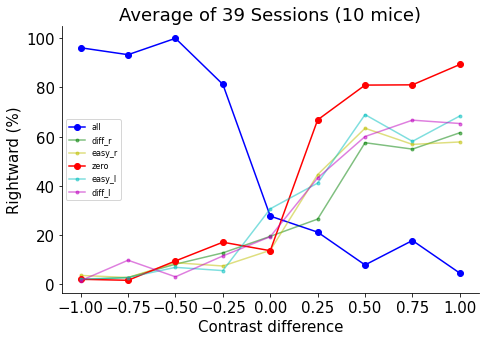

In [54]:
    fig = plt.figure(figsize=(7,5))

    xdata = np.unique(cont_diff)
    plt.plot(xdata, rightward, 'bo-', label='all')
    plt.plot(xdata, rdr, 'g.-',   label='diff_r', alpha=0.5)
    plt.plot(xdata, rer, 'y.-',  label='easy_r', alpha=0.5)
    plt.plot(xdata, rz , 'ro-',   label='zero')
    plt.plot(xdata, rel, 'c.-',  label='easy_l', alpha=0.5)
    plt.plot(xdata, rdl, 'm.-',   label='diff_l', alpha=0.5)

    plt.xlabel('Contrast difference')
    plt.ylabel('Rightward (%)')
    plt.title('Average of 39 Sessions (10 mice)')
    plt.legend(fontsize=8)
    plt.show()

## Modeling

In [55]:
dat['spks'].shape

(1348, 343, 250)

In [56]:
(np.ones(3).reshape(-1,1)).shape

(3, 1)

In [57]:
X=(np.linspace(-10,10,20)*np.ones(5).reshape(-1,1)).T

In [58]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(penalty="none") # initialize the model with a hyperparameter. 

# X matrix: (n_samples, n_features)
# y vector: (n_samples)
# X = np.ones((20,5))
y = np.concatenate((np.zeros(10), np.ones(10)), axis=0)
log_reg.fit(X, y) # fit the model

LogisticRegression(penalty='none')

In [59]:
y_pred = log_reg.predict(X)

### Psychometric Function Modeling (four-parameter logistic function)

Curve fitting reference: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

In [60]:
from scipy.optimize import curve_fit

In [61]:
from functions import func
# def func(x,x0,y0,a,b):
#     '''
#     Four-parameter logistic function for model fitting
#     '''
#     return y0 + a/(1+np.exp(-(x-x0)/b))

ImportError: cannot import name 'func' from 'functions' (C:\Users\Akihiro\Documents\GitHub\NMA2020\Project_decision dinos\functions.py)

In [ ]:
def psyc(x,x0,y0,a,b, mu, sigma): 
    '''
    Four-parameter logistic function with noise (normal distributed) for sample data
    '''
    noise = np.random.normal(mu, sigma, np.array(x.shape[0]))
    return y0 + a/(1+np.exp(-(x-x0)/b)) + noise

In [ ]:
N = 90 # number of points
xdata = np.linspace(-10,10,N)
ytrue = func(xdata, 0, 1,0.5)*10
ydata = ytrue + np.random.normal(0,0.5, np.array(xdata.shape[0]))

# Compute fit
popt, pcov = curve_fit(func, xdata, ydata)

# Plot stuff
fig = plt.figure(figsize=(6,4))
plt.plot(xdata, ytrue, label='true curve')
plt.plot(xdata, ydata,'r.', label='sample (pseudo) data')
plt.plot(xdata, func(xdata, *popt), 'g--',
         label='fit: x0=%5.3f, a=%5.3f, b=%5.3f' % tuple(popt))
plt.legend(loc='upper left', fontsize=10)
plt.plot()

## Test fitting 

In [ ]:
fig = plt.figure(figsize=(6,4))

xdata = np.unique(cont_diff)
ydata = r_zero/10
# print(ydata)

plt.plot(xdata, ydata,'.-',   label='diff_l data (%1.0f)'%n_trials[2])

popt, pcov = curve_fit(func, xdata, ydata, maxfev=1000)
plt.plot(xdata, func(xdata, *popt), 'g--',
         label='fit: x0=%5.3f, a=%5.3f, b=%5.3f' % tuple(popt))

plt.xlabel('Contrast difference')
plt.ylabel('Rightward (%)')
plt.title('Session: %1.0f, '%n_session + dat['mouse_name'])
plt.legend(loc='upper left', fontsize=10)
plt.show()

## Psychometric Function Model Fitting (CDF)